## We have divided the problem into two parts
(a) Predict the floor number
(b) Predict the way points or location on that floor

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir
from pathlib import Path
pd.options.mode.chained_assignment = None  # default='warn'
from dataclasses import dataclass
from sklearn import preprocessing

In [ ]:
import keras
from keras.utils import to_categorical
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Bidirectional

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Function to connect waypoint coordinates with straight lines
#This will be used for second part of project.We will discuss about this later.
def connect_waypoints(wp_df):
  if(wp_df.at[0,'waypoint_val1']==''):
    wp_df.at[0,'waypoint_val1']=0
  if(wp_df.at[0,'waypoint_val2']==''):
    wp_df.at[0,'waypoint_val2']=0  
  j=0
  i=0
  last=0
  #print(wp_df.head(5))
  while i < (len(wp_df)-1):
    j=i+1
    while((wp_df.at[j,'waypoint_val1']==0) and (wp_df.at[j,'waypoint_val2']==0) ):
      if(j==len(wp_df)-1):
        wp_df.at[j,'waypoint_val1']=wp_df.at[i,'waypoint_val1']
        wp_df.at[j,'waypoint_val2']=wp_df.at[i,'waypoint_val2']
        last=1
        break
      j+=1
    temp_arrayx=np.linspace(wp_df.at[i,'waypoint_val1'],wp_df.at[j,'waypoint_val1'], num=j-i+1)
    temp_arrayy=np.linspace(wp_df.at[i,'waypoint_val2'],wp_df.at[j,'waypoint_val2'], num=j-i+1)
    #print(temp_arrayx)
    m=0
    for k in range(i,j+1):
      wp_df.at[k,'waypoint_val1']=temp_arrayx[m]
      wp_df.at[k,'waypoint_val2']=temp_arrayy[m]
      #For final comparison of our predicted location, we will need to mark which waypoints were in original data before connecting them
      #print('k=',k,'i=',i,'j=',j)
      if((k==i) and (last==0)):
        wp_df.at[k,'interpolated']=1 #original waypoints
      else:
        wp_df.at[k,'interpolated']=0  #interpolated waypoints
      m+=1
    i=j
  return wp_df     


In [ ]:
# Function to extract arrays for each sensor with timeslots.
# This particular function is modified from the function provided by the competition's github page at https://github.com/location-competition/indoor-location-competition-20/blob/master/io_f.py

@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []
    line_count=0
    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        #line_count=line_count+1
        #if(line_count>3000):
        #  break
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = int(line_data[0])
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = int(line_data[0])
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

    acce = np.array(acce,dtype=np.float)
    acce_uncali = np.array(acce_uncali,dtype=np.float)
    gyro = np.array(gyro,dtype=np.float)
    gyro_uncali = np.array(gyro_uncali,dtype=np.float)
    magn = np.array(magn,dtype=np.float)
    magn_uncali = np.array(magn_uncali,dtype=np.float)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

In [ ]:
#Function to go through all the files in the folder and return the sensor data 
# in the form of arrays
@dataclass
class trace:
    sequence: np.ndarray
    target_seq: np.ndarray
    waypoint_seq: np.ndarray
    wp_full_seq: np.ndarray

def convert_to_df(file_path,floor,timeslots):
    pathlist = Path(file_path).rglob('*.txt')
    sequence = list()
    target_seq=list()
    waypoint_seq=list()
    wp_full_seq=list()
    path_id=1
    floor_trace_df=pd.DataFrame()
    for path in pathlist:
         # because path is object not string
        path_in_str = str(path)
         # print(path_in_str)
        trace_file = read_data_file(path_in_str)
        trace_df=pd.DataFrame()
        if(trace_file.acce.size):
            acce_df=pd.DataFrame(trace_file.acce, columns=['Timestamp','acce_val1','acce_val2','acce_val3'])
        if(trace_file.acce_uncali.size):
            acce__uncal_df=pd.DataFrame(trace_file.acce_uncali, columns=['Timestamp','acce_uncal_val1','acce_uncal_val2','acce_uncal_val3'])   
        if(trace_file.gyro.size):
            gyro_df=pd.DataFrame(trace_file.gyro, columns=['Timestamp','gyro_val1','gyro_val2','gyro_val3'])
        if(trace_file.gyro_uncali.size):
            gyro_uncal_df=pd.DataFrame(trace_file.gyro_uncali, columns=['Timestamp','gyro_uncal_val1','gyro_uncal_val2','gyro_uncal_val3'])
        if(trace_file.magn.size):
            magn_df=pd.DataFrame(trace_file.magn, columns=['Timestamp','magn_val1','magn_val2','magn_val3'])
        if(trace_file.magn_uncali.size):
            magn_uncal_df=pd.DataFrame(trace_file.magn_uncali, columns=['Timestamp','magn_uncal_val1','magn_uncal_val2','magn_uncal_val3'])
        if(trace_file.ahrs.size):
            rot_df=pd.DataFrame(trace_file.ahrs, columns=['Timestamp','rot_val1','rot_val2','rot_val3'])           
        if(trace_file.wifi.size):
            wifi_df=pd.DataFrame(trace_file.wifi, columns=['Timestamp','wifi_val1','wifi_val2','wifi_val3','wifi_val4']) 
        if(trace_file.ibeacon.size):
            ibeacon_df=pd.DataFrame(trace_file.ibeacon, columns=['Timestamp','ibeacon_val1','ibeacon_val2'])    
        if(trace_file.waypoint.size):
            waypoint_df=pd.DataFrame(trace_file.waypoint, columns=['Timestamp','waypoint_val1','waypoint_val2'])
        
        #change data type of wifi dataframe timestamp and ibeacon timestamp
        wifi_df["Timestamp"] = wifi_df.Timestamp.astype(float)
        ibeacon_df["Timestamp"] = ibeacon_df.Timestamp.astype(float)
        trace_df = pd.merge(acce_df, acce__uncal_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, gyro_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, gyro_uncal_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, magn_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, magn_uncal_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, rot_df, on='Timestamp', how='outer')
        #trace_df = pd.merge(trace_df, wifi_df, on='Timestamp', how='outer')
        #trace_df = pd.merge(trace_df, ibeacon_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, waypoint_df, on='Timestamp', how='outer')
        ###### Cast time stamp to integer
        trace_df["Timestamp"] = trace_df.Timestamp.astype(int)

        # sorting by Timestamp and deleting duplicate timeslots 
        
        trace_df.sort_values("Timestamp", inplace = True)
        trace_df = trace_df.reset_index(drop=True)
        trace_df.drop_duplicates(subset="Timestamp",keep=False, inplace=True)
        trace_df = trace_df.reset_index(drop=True)
        
        trace_df=trace_df.replace(np.nan,0)

        #keep only top 200 rows in one sequence     
        #trace_df=trace_df.head(200)

        #for i in range(0,len(trace_df)):
         # trace_df.at[i,'Timestamp']=i
        
        #trace_df['time_index'] = trace_df.index
        #print(trace_df.head())
        #trace_df['floor_name']=floor
        #trace_df['path_id']=floor+path_id
        #path_id=path_id+1
        #trace_df['wifi_df'].fillna(0)
        #trace_df['ibeacon_df'].fillna(0)
        #trace_df['wifi_df'].fillna(0)
        

        wp_df = trace_df[['waypoint_val1', 'waypoint_val2']].copy()
        wp_df=connect_waypoints(wp_df)
        wp_values=wp_df.values
        #Removing text based fields in dataframe
        trace_df=trace_df.drop(['Timestamp'], axis=1)
        #trace_df=trace_df.drop(['wifi_val1'], axis=1)
        #trace_df=trace_df.drop(['wifi_val2'], axis=1)
        #trace_df=trace_df.drop(['ibeacon_val1'], axis=1)
        trace_df.astype('float32')        
        trace_df=trace_df.drop(['waypoint_val1','waypoint_val2'], axis=1)
        #floor_trace_df=floor_trace_df.append(trace_df)
        values = trace_df.values 


        


        #Now split sequence into required number of timeslots
        l=int(len(values)/timeslots)
        k=0
        for m in range(l):
          s_temp=values[k:k+timeslots]
          wp_temp=wp_values[k:k+timeslots]
          #Normalize
          #min_max_scaler = preprocessing.MinMaxScaler()
          #s_scaled = min_max_scaler.fit_transform(s_temp)
          sequence.append(s_temp)
          wp_full_seq.append(wp_temp)
          target_seq.append(floor)
          wp_temp=wp_df.iloc[k:k+timeslots,0:]
          wp_temp=wp_temp.reset_index(drop=True)
          #wp_temp=connect_waypoints(wp_temp)
        #Now after connecting the waypoints, the avearge has become a wieghted average in time series
          wp_avg_x=wp_temp['waypoint_val1'].mean()
          wp_avg_y=wp_temp['waypoint_val2'].mean()
        #maximum and minimum will be useful in second part
          wp_max_x=wp_temp['waypoint_val1'].max()
          wp_min_x=wp_temp['waypoint_val1'].min()
          wp_max_y=wp_temp['waypoint_val2'].max()
          wp_min_y=wp_temp['waypoint_val2'].min()
          
          waypoint_seq.append([wp_avg_x,wp_avg_y,wp_max_x,wp_min_x,wp_max_y,wp_min_y])
          k+=timeslots

    return trace(sequence,target_seq,waypoint_seq,wp_full_seq)

In [ ]:
#Extracting data for B1 floor only
sequences = list()
target_sequence=list()
waypoint_sequence=list()
waypoint_full_sequence=list()
#floors_df=pd.DataFrame()
file_path = '/content/drive/MyDrive/building1/data/B1'
trace_values=(convert_to_df(file_path,0,5))
sequences.extend(trace_values.sequence)
target_sequence.extend(trace_values.target_seq)
waypoint_sequence.extend(trace_values.waypoint_seq)
waypoint_full_sequence.extend(trace_values.wp_full_seq)

In [ ]:
len(waypoint_sequence)

38874

In [ ]:
len(sequences[0])

5

In [ ]:
print('Number of sequences',len(sequences))
print('Number of targets',len(target_sequence))
print('Number of timeslots in first sequence',(sequences[0].shape)[0])
print('Number of timeslots in tenth sequence',(sequences[9].shape)[0])
print('Number of timeslots in hundredth sequence',(sequences[99].shape)[0])

Number of sequences 38874
Number of targets 38874
Number of timeslots in first sequence 5
Number of timeslots in tenth sequence 5
Number of timeslots in hundredth sequence 5


# Part 2 

### After knowing the floor, now we need to predict waypoints on that floor.

### We assume that floor B1 was predicted in first part. So, for this part we will only take data of floor B1.

In [ ]:
len(waypoint_sequence)

38874

In [ ]:
len(sequences)

38874

In [ ]:
##We will divide the area into grids. But first we need to know the dimensions to work with
wp_df = pd.DataFrame(waypoint_sequence, columns = ['avg_x','avg_y','max_x','min_x','max_y','min_y',])
wp_df=wp_df.head(len(sequences))  #number of sequences for floor B1
wp_df = wp_df.round(decimals=5)
floor_max_x=wp_df['max_x'].max()
floor_min_x=wp_df['min_x'].min()
floor_max_y=wp_df['max_y'].max()
floor_min_y=wp_df['min_y'].min()
print(floor_max_x,floor_min_x,floor_max_y,floor_min_y)

233.94418 36.63454 192.99721 75.00506


In [ ]:
#Creating grid for labelling
#We will create a 15X15 grid for 225 labels
array_x=np.linspace(floor_min_x,floor_max_x,16)
array_y=np.linspace(floor_min_y,floor_max_y,16)
label=list()
k=0
for j in range(1,16):
  for i in range(1,16):
    label.append([array_x[i],array_y[j],k])
    k+=1  

In [ ]:
#Now we need to give labels to our waypoints sequence on the basis of average waypoints
print(wp_df.head())
for i in range(len(wp_df)):
  for j in range(len(label)):
    if(wp_df.at[i,'avg_x']<=label[j][0]):
       for p in range(len(label)):
         if(wp_df.at[i,'avg_y']<=label[p][1]):
           wp_df.at[i,'label']=label[j+p][2]
           break
       break    
print(wp_df.head(20))           

       avg_x      avg_y      max_x      min_x      max_y      min_y
0  198.39960  163.51350  198.43087  198.36833  163.52063  163.50637
1  198.47778  163.49568  198.50905  198.44651  163.50281  163.48855
2  198.55596  163.47785  198.58723  198.52469  163.48498  163.47072
3  198.63414  163.46003  198.66541  198.60287  163.46716  163.45290
4  198.71232  163.44220  198.74359  198.68105  163.44933  163.43507
        avg_x      avg_y      max_x      min_x      max_y      min_y  label
0   198.39960  163.51350  198.43087  198.36833  163.52063  163.50637  177.0
1   198.47778  163.49568  198.50905  198.44651  163.50281  163.48855  177.0
2   198.55596  163.47785  198.58723  198.52469  163.48498  163.47072  177.0
3   198.63414  163.46003  198.66541  198.60287  163.46716  163.45290  177.0
4   198.71232  163.44220  198.74359  198.68105  163.44933  163.43507  177.0
5   198.79050  163.42438  198.82177  198.75923  163.43151  163.41725  177.0
6   198.86868  163.40656  198.89995  198.83741  163.41369  1

In [ ]:
#Now we need to create new train, validation and test split for only building 1
train_length=int(len(sequences)*0.7)
val_length=int(len(sequences)*0.15)
test_length=len(sequences)-train_length-val_length

train_flags=np.full((train_length), 0)
validation_flags=np.full((val_length), 1)
test_flags=np.full((test_length), 2)

flags=[]
flags.extend(train_flags)
flags.extend(validation_flags)
flags.extend(test_flags)
np.random.shuffle(flags)
len(flags)

38874

In [ ]:
#Creating target sequence
target_sequence2=wp_df['label'].values
#Slice the sequence to get only floor B1 data
sequences2=sequences[0:len(sequences)]
target_sequence2=np.array(target_sequence2)
target_sequence2

array([177., 177., 177., ..., 154., 154., 154.])

In [ ]:
train = [sequences2[i] for i in range(len(flags)) if (flags[i]==0)]
validation = [sequences2[i] for i in range(len(flags)) if flags[i]==1]
test = [sequences2[i] for i in range(len(flags)) if flags[i]==2]
test_seq_wp=[waypoint_full_sequence[i] for i in range(len(flags)) if flags[i]==2]

train_target = [target_sequence2[i] for i in range(len(flags)) if (flags[i]==0)]
validation_target = [target_sequence2[i] for i in range(len(flags)) if flags[i]==1]
test_target = [target_sequence2[i] for i in range(len(flags)) if flags[i]==2]
train = np.array(train)
validation = np.array(validation)
test = np.array(test)

train_target = np.array(train_target)
train_target=to_categorical(train_target,num_classes = 225)

validation_target = np.array(validation_target)
validation_target=to_categorical(validation_target,num_classes = 225)
test_target = np.array(test_target)
test_target=to_categorical(test_target,num_classes = 225)

In [ ]:
print(sequences2[0].shape)
train_target[0]
len(test_seq_wp)

(5, 21)


5832

In [ ]:
train=tf.convert_to_tensor(train, np.float32)
train_target=tf.convert_to_tensor(train_target, np.float32)
validation=tf.convert_to_tensor(validation, np.float32)
validation_target=tf.convert_to_tensor(validation_target, np.float32)
test=tf.convert_to_tensor(test, np.float32)
test_target=tf.convert_to_tensor(test_target, np.float32)

In [ ]:
#Trial with 100 grid cells 
from keras.layers import Dropout
seq_len = 5
seq_bredth=21
model = Sequential()
model.add(Bidirectional(LSTM(512,return_sequences=True),input_shape=(seq_len, seq_bredth),merge_mode='concat'))
model.add(Dropout(0.2))
model.add(LSTM(512, input_shape=(3, 512)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(225, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5, 1024)           2187264   
_________________________________________________________________
dropout (Dropout)            (None, 5, 1024)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               3147776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 225)               5

In [ ]:
#This is 100 cells simple LSTM
adam = Adam(lr=0.001)
checkpoint_filepath = '/content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl'
chk = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model.fit(train, train_target, epochs=200, batch_size=128, callbacks=[chk], validation_data=(validation,validation_target))

Epoch 1/200
213/213 [==============================] - 96s 431ms/step - loss: 4.3174 - accuracy: 0.0404 - val_loss: 3.2343 - val_accuracy: 0.1511

Epoch 00001: val_accuracy improved from -inf to 0.15109, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 2/200
213/213 [==============================] - 91s 425ms/step - loss: 3.0678 - accuracy: 0.1648 - val_loss: 2.2533 - val_accuracy: 0.3197

Epoch 00002: val_accuracy improved from 0.15109 to 0.31967, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 3/200
213/213 [==============================] - 91s 427ms/step - loss: 2.2591 - accuracy: 0.3010 - val_loss: 1.8817 - val_accuracy: 0.3998

Epoch 00003: val_accuracy improved from 0.31967 to 0.39976, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 4/200
213/213 [==============================] - 91s 428ms/step - loss: 1.9056 - accuracy: 0.3733 - val_loss: 1.6942 - val_accuracy: 0.4353

Epoch 00004: val_accuracy improved from 0.39976 to 0.43526, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 5/200
213/213 [==============================] - 91s 427ms/step - loss: 1.7119 - accuracy: 0.4248 - val_loss: 1.5212 - val_accuracy: 0.4716

Epoch 00005: val_accuracy improved from 0.43526 to 0.47162, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 6/200
213/213 [==============================] - 91s 427ms/step - loss: 1.6292 - accuracy: 0.4534 - val_loss: 1.3774 - val_accuracy: 0.5286

Epoch 00006: val_accuracy improved from 0.47162 to 0.52855, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 7/200
213/213 [==============================] - 91s 427ms/step - loss: 1.4886 - accuracy: 0.4821 - val_loss: 1.4440 - val_accuracy: 0.5042

Epoch 00007: val_accuracy did not improve from 0.52855
Epoch 8/200
213/213 [==============================] - 91s 427ms/step - loss: 1.4115 - accuracy: 0.5078 - val_loss: 1.4272 - val_accuracy: 0.5155

Epoch 00008: val_accuracy did not improve from 0.52855
Epoch 9/200
213/213 [==============================] - 91s 427ms/step - loss: 1.3594 - accuracy: 0.5212 - val_loss: 1.1763 - val_accuracy: 0.5805

Epoch 00009: val_accuracy improved from 0.52855 to 0.58052, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 10/200
213/213 [==============================] - 91s 429ms/step - loss: 1.3026 - accuracy: 0.5464 - val_loss: 1.2190 - val_accuracy: 0.5694

Epoch 00010: val_accuracy did not improve from 0.58052
Epoch 11/200
213/213 [==============================] - 91s 427ms/step - loss: 1.2300 - accuracy: 0.5657 - val_loss: 1.1020 - val_accuracy: 0.6097

Epoch 00011: val_accuracy improved from 0.58052 to 0.60967, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 12/200
213/213 [==============================] - 92s 430ms/step - loss: 1.1789 - accuracy: 0.5869 - val_loss: 1.0433 - val_accuracy: 0.6316

Epoch 00012: val_accuracy improved from 0.60967 to 0.63162, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 13/200
213/213 [==============================] - 92s 434ms/step - loss: 1.1022 - accuracy: 0.6098 - val_loss: 0.9975 - val_accuracy: 0.6424

Epoch 00013: val_accuracy improved from 0.63162 to 0.64243, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 14/200
213/213 [==============================] - 92s 433ms/step - loss: 1.0744 - accuracy: 0.6217 - val_loss: 1.0333 - val_accuracy: 0.6357

Epoch 00014: val_accuracy did not improve from 0.64243
Epoch 15/200
213/213 [==============================] - 92s 432ms/step - loss: 1.0154 - accuracy: 0.6342 - val_loss: 1.0076 - val_accuracy: 0.6453

Epoch 00015: val_accuracy improved from 0.64243 to 0.64534, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 16/200
213/213 [==============================] - 92s 434ms/step - loss: 0.9862 - accuracy: 0.6462 - val_loss: 0.9875 - val_accuracy: 0.6476

Epoch 00016: val_accuracy improved from 0.64534 to 0.64757, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 17/200
213/213 [==============================] - 93s 435ms/step - loss: 0.9654 - accuracy: 0.6545 - val_loss: 0.9296 - val_accuracy: 0.6733

Epoch 00017: val_accuracy improved from 0.64757 to 0.67330, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 18/200
213/213 [==============================] - 93s 436ms/step - loss: 0.9259 - accuracy: 0.6598 - val_loss: 0.9095 - val_accuracy: 0.6796

Epoch 00018: val_accuracy improved from 0.67330 to 0.67964, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 19/200
213/213 [==============================] - 93s 436ms/step - loss: 0.8448 - accuracy: 0.6946 - val_loss: 0.9438 - val_accuracy: 0.6634

Epoch 00019: val_accuracy did not improve from 0.67964
Epoch 20/200
213/213 [==============================] - 92s 434ms/step - loss: 0.8174 - accuracy: 0.7006 - val_loss: 0.8321 - val_accuracy: 0.6999

Epoch 00020: val_accuracy improved from 0.67964 to 0.69988, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 21/200
213/213 [==============================] - 93s 434ms/step - loss: 0.8019 - accuracy: 0.7090 - val_loss: 0.8554 - val_accuracy: 0.6935

Epoch 00021: val_accuracy did not improve from 0.69988
Epoch 22/200
213/213 [==============================] - 92s 434ms/step - loss: 0.8221 - accuracy: 0.7047 - val_loss: 0.8931 - val_accuracy: 0.6836

Epoch 00022: val_accuracy did not improve from 0.69988
Epoch 23/200
213/213 [==============================] - 92s 434ms/step - loss: 0.7443 - accuracy: 0.7304 - val_loss: 0.7697 - val_accuracy: 0.7225

Epoch 00023: val_accuracy improved from 0.69988 to 0.72252, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 24/200
213/213 [==============================] - 92s 434ms/step - loss: 0.7115 - accuracy: 0.7375 - val_loss: 0.8427 - val_accuracy: 0.7050

Epoch 00024: val_accuracy did not improve from 0.72252
Epoch 25/200
213/213 [==============================] - 93s 435ms/step - loss: 0.7721 - accuracy: 0.7278 - val_loss: 0.8072 - val_accuracy: 0.7061

Epoch 00025: val_accuracy did not improve from 0.72252
Epoch 26/200
213/213 [==============================] - 91s 429ms/step - loss: 0.7074 - accuracy: 0.7446 - val_loss: 0.7714 - val_accuracy: 0.7170

Epoch 00026: val_accuracy did not improve from 0.72252
Epoch 27/200
213/213 [==============================] - 92s 431ms/step - loss: 0.6444 - accuracy: 0.7691 - val_loss: 0.8394 - val_accuracy: 0.7047

Epoch 00027: val_accuracy did not improve from 0.72252
Epoch 28/200
213/213 [==============================] - 99s 465ms/step - loss: 0.6731 - accuracy: 0.7545 - val_loss: 0.7822 - val_accuracy: 0.7241

Epoch 00028: val_accuracy improved from 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 29/200
213/213 [==============================] - 97s 455ms/step - loss: 0.6072 - accuracy: 0.7789 - val_loss: 0.7778 - val_accuracy: 0.7241

Epoch 00029: val_accuracy did not improve from 0.72406
Epoch 30/200
213/213 [==============================] - 95s 447ms/step - loss: 0.5946 - accuracy: 0.7832 - val_loss: 0.6985 - val_accuracy: 0.7515

Epoch 00030: val_accuracy improved from 0.72406 to 0.75150, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 31/200
213/213 [==============================] - 93s 438ms/step - loss: 0.5827 - accuracy: 0.7894 - val_loss: 0.7638 - val_accuracy: 0.7287

Epoch 00031: val_accuracy did not improve from 0.75150
Epoch 32/200
213/213 [==============================] - 93s 436ms/step - loss: 0.5687 - accuracy: 0.7926 - val_loss: 0.8066 - val_accuracy: 0.7222

Epoch 00032: val_accuracy did not improve from 0.75150
Epoch 33/200
213/213 [==============================] - 94s 440ms/step - loss: 0.5505 - accuracy: 0.7970 - val_loss: 0.8442 - val_accuracy: 0.7172

Epoch 00033: val_accuracy did not improve from 0.75150
Epoch 34/200
213/213 [==============================] - 94s 441ms/step - loss: 0.5218 - accuracy: 0.8090 - val_loss: 0.7457 - val_accuracy: 0.7441

Epoch 00034: val_accuracy did not improve from 0.75150
Epoch 35/200
213/213 [==============================] - 92s 434ms/step - loss: 0.5862 - accuracy: 0.7933 - val_loss: 0.6750 - val_accuracy: 0.7594

Epoch 00035: val_accuracy improved from 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 36/200
213/213 [==============================] - 96s 449ms/step - loss: 0.5356 - accuracy: 0.8042 - val_loss: 0.6722 - val_accuracy: 0.7668

Epoch 00036: val_accuracy improved from 0.75939 to 0.76676, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 37/200
213/213 [==============================] - 96s 453ms/step - loss: 0.4936 - accuracy: 0.8174 - val_loss: 0.6685 - val_accuracy: 0.7683

Epoch 00037: val_accuracy improved from 0.76676 to 0.76831, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 38/200
213/213 [==============================] - 95s 445ms/step - loss: 0.4682 - accuracy: 0.8268 - val_loss: 0.6693 - val_accuracy: 0.7668

Epoch 00038: val_accuracy did not improve from 0.76831
Epoch 39/200
213/213 [==============================] - 92s 434ms/step - loss: 0.4579 - accuracy: 0.8344 - val_loss: 0.6557 - val_accuracy: 0.7714

Epoch 00039: val_accuracy improved from 0.76831 to 0.77139, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 40/200
213/213 [==============================] - 93s 436ms/step - loss: 0.4892 - accuracy: 0.8210 - val_loss: 0.7094 - val_accuracy: 0.7529

Epoch 00040: val_accuracy did not improve from 0.77139
Epoch 41/200
213/213 [==============================] - 92s 433ms/step - loss: 0.4343 - accuracy: 0.8426 - val_loss: 0.7092 - val_accuracy: 0.7659

Epoch 00041: val_accuracy did not improve from 0.77139
Epoch 42/200
213/213 [==============================] - 92s 433ms/step - loss: 0.4469 - accuracy: 0.8361 - val_loss: 0.7474 - val_accuracy: 0.7486

Epoch 00042: val_accuracy did not improve from 0.77139
Epoch 43/200
213/213 [==============================] - 92s 434ms/step - loss: 0.4262 - accuracy: 0.8436 - val_loss: 0.6401 - val_accuracy: 0.7800

Epoch 00043: val_accuracy improved from 0.77139 to 0.77997, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 44/200
213/213 [==============================] - 94s 440ms/step - loss: 0.4466 - accuracy: 0.8422 - val_loss: 0.6523 - val_accuracy: 0.7805

Epoch 00044: val_accuracy improved from 0.77997 to 0.78048, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 45/200
213/213 [==============================] - 95s 445ms/step - loss: 0.3789 - accuracy: 0.8612 - val_loss: 0.7053 - val_accuracy: 0.7652

Epoch 00045: val_accuracy did not improve from 0.78048
Epoch 46/200
213/213 [==============================] - 93s 438ms/step - loss: 0.4118 - accuracy: 0.8466 - val_loss: 0.6848 - val_accuracy: 0.7716

Epoch 00046: val_accuracy did not improve from 0.78048
Epoch 47/200
213/213 [==============================] - 93s 436ms/step - loss: 0.3948 - accuracy: 0.8555 - val_loss: 0.7559 - val_accuracy: 0.7537

Epoch 00047: val_accuracy did not improve from 0.78048
Epoch 48/200
213/213 [==============================] - 93s 436ms/step - loss: 0.3882 - accuracy: 0.8579 - val_loss: 0.6694 - val_accuracy: 0.7798

Epoch 00048: val_accuracy did not improve from 0.78048
Epoch 49/200
213/213 [==============================] - 93s 437ms/step - loss: 0.3573 - accuracy: 0.8655 - val_loss: 0.6665 - val_accuracy: 0.7788

Epoch 00049: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 52/200
213/213 [==============================] - 93s 436ms/step - loss: 0.3529 - accuracy: 0.8731 - val_loss: 0.6307 - val_accuracy: 0.7957

Epoch 00052: val_accuracy improved from 0.78580 to 0.79575, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 53/200
213/213 [==============================] - 93s 438ms/step - loss: 0.3325 - accuracy: 0.8786 - val_loss: 0.6687 - val_accuracy: 0.7841

Epoch 00053: val_accuracy did not improve from 0.79575
Epoch 54/200
213/213 [==============================] - 93s 435ms/step - loss: 0.3432 - accuracy: 0.8761 - val_loss: 0.6566 - val_accuracy: 0.7875

Epoch 00054: val_accuracy did not improve from 0.79575
Epoch 55/200
213/213 [==============================] - 93s 435ms/step - loss: 0.3352 - accuracy: 0.8791 - val_loss: 0.6457 - val_accuracy: 0.7858

Epoch 00055: val_accuracy did not improve from 0.79575
Epoch 56/200
213/213 [==============================] - 93s 436ms/step - loss: 0.3046 - accuracy: 0.8894 - val_loss: 0.6620 - val_accuracy: 0.7865

Epoch 00056: val_accuracy did not improve from 0.79575
Epoch 57/200
213/213 [==============================] - 93s 435ms/step - loss: 0.3650 - accuracy: 0.8673 - val_loss: 0.8225 - val_accuracy: 0.7510

Epoch 00057: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 60/200
213/213 [==============================] - 93s 438ms/step - loss: 0.2917 - accuracy: 0.8957 - val_loss: 0.6625 - val_accuracy: 0.7973

Epoch 00060: val_accuracy did not improve from 0.80021
Epoch 61/200
213/213 [==============================] - 93s 438ms/step - loss: 0.3597 - accuracy: 0.8740 - val_loss: 0.6403 - val_accuracy: 0.7964

Epoch 00061: val_accuracy did not improve from 0.80021
Epoch 62/200
213/213 [==============================] - 93s 436ms/step - loss: 0.2779 - accuracy: 0.8990 - val_loss: 0.7099 - val_accuracy: 0.7765

Epoch 00062: val_accuracy did not improve from 0.80021
Epoch 63/200
213/213 [==============================] - 93s 435ms/step - loss: 0.3183 - accuracy: 0.8876 - val_loss: 0.7155 - val_accuracy: 0.7795

Epoch 00063: val_accuracy did not improve from 0.80021
Epoch 64/200
213/213 [==============================] - 93s 437ms/step - loss: 0.2889 - accuracy: 0.8965 - val_loss: 0.7643 - val_accuracy: 0.7752

Epoch 00064: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 71/200
213/213 [==============================] - 92s 434ms/step - loss: 0.2717 - accuracy: 0.9029 - val_loss: 0.6829 - val_accuracy: 0.7920

Epoch 00071: val_accuracy did not improve from 0.80415
Epoch 72/200
213/213 [==============================] - 92s 432ms/step - loss: 0.2516 - accuracy: 0.9079 - val_loss: 0.6825 - val_accuracy: 0.8017

Epoch 00072: val_accuracy did not improve from 0.80415
Epoch 73/200
213/213 [==============================] - 92s 433ms/step - loss: 0.2445 - accuracy: 0.9114 - val_loss: 0.6457 - val_accuracy: 0.8076

Epoch 00073: val_accuracy improved from 0.80415 to 0.80758, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 74/200
213/213 [==============================] - 92s 434ms/step - loss: 0.2471 - accuracy: 0.9108 - val_loss: 0.7686 - val_accuracy: 0.7788

Epoch 00074: val_accuracy did not improve from 0.80758
Epoch 75/200
213/213 [==============================] - 92s 433ms/step - loss: 0.2665 - accuracy: 0.9041 - val_loss: 0.6721 - val_accuracy: 0.8023

Epoch 00075: val_accuracy did not improve from 0.80758
Epoch 76/200
213/213 [==============================] - 92s 433ms/step - loss: 0.2442 - accuracy: 0.9125 - val_loss: 0.6759 - val_accuracy: 0.7980

Epoch 00076: val_accuracy did not improve from 0.80758
Epoch 77/200
213/213 [==============================] - 92s 432ms/step - loss: 0.2352 - accuracy: 0.9170 - val_loss: 0.8112 - val_accuracy: 0.7578

Epoch 00077: val_accuracy did not improve from 0.80758
Epoch 78/200
213/213 [==============================] - 92s 432ms/step - loss: 0.2914 - accuracy: 0.8977 - val_loss: 0.6691 - val_accuracy: 0.8033

Epoch 00078: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 81/200
213/213 [==============================] - 92s 433ms/step - loss: 0.2147 - accuracy: 0.9249 - val_loss: 0.6974 - val_accuracy: 0.7999

Epoch 00081: val_accuracy did not improve from 0.81050
Epoch 82/200
213/213 [==============================] - 92s 431ms/step - loss: 0.3168 - accuracy: 0.8973 - val_loss: 0.6518 - val_accuracy: 0.8069

Epoch 00082: val_accuracy did not improve from 0.81050
Epoch 83/200
213/213 [==============================] - 91s 429ms/step - loss: 0.2223 - accuracy: 0.9201 - val_loss: 0.6886 - val_accuracy: 0.8078

Epoch 00083: val_accuracy did not improve from 0.81050
Epoch 84/200
213/213 [==============================] - 92s 431ms/step - loss: 0.1963 - accuracy: 0.9299 - val_loss: 0.7134 - val_accuracy: 0.7959

Epoch 00084: val_accuracy did not improve from 0.81050
Epoch 85/200
213/213 [==============================] - 92s 431ms/step - loss: 0.2330 - accuracy: 0.9174 - val_loss: 0.7481 - val_accuracy: 0.7851

Epoch 00085: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 102/200
213/213 [==============================] - 93s 439ms/step - loss: 0.2169 - accuracy: 0.9276 - val_loss: 0.7203 - val_accuracy: 0.8139

Epoch 00102: val_accuracy improved from 0.81358 to 0.81393, saving model to /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 103/200
213/213 [==============================] - 99s 464ms/step - loss: 0.1614 - accuracy: 0.9422 - val_loss: 0.7770 - val_accuracy: 0.8040

Epoch 00103: val_accuracy did not improve from 0.81393
Epoch 104/200
213/213 [==============================] - 100s 471ms/step - loss: 0.1760 - accuracy: 0.9359 - val_loss: 0.9991 - val_accuracy: 0.7549

Epoch 00104: val_accuracy did not improve from 0.81393
Epoch 105/200
213/213 [==============================] - 96s 453ms/step - loss: 0.2396 - accuracy: 0.9216 - val_loss: 0.7273 - val_accuracy: 0.8062

Epoch 00105: val_accuracy did not improve from 0.81393
Epoch 106/200
213/213 [==============================] - 94s 439ms/step - loss: 0.1796 - accuracy: 0.9386 - val_loss: 0.7501 - val_accuracy: 0.8036

Epoch 00106: val_accuracy did not improve from 0.81393
Epoch 107/200
213/213 [==============================] - 93s 438ms/step - loss: 0.1419 - accuracy: 0.9497 - val_loss: 0.7705 - val_accuracy: 0.8066

Epoch 00107: val_accuracy did not 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl/assets


Epoch 119/200
213/213 [==============================] - 93s 436ms/step - loss: 0.1429 - accuracy: 0.9500 - val_loss: 0.8398 - val_accuracy: 0.7987

Epoch 00119: val_accuracy did not improve from 0.81598
Epoch 120/200
213/213 [==============================] - 93s 435ms/step - loss: 0.1622 - accuracy: 0.9443 - val_loss: 0.7651 - val_accuracy: 0.8156

Epoch 00120: val_accuracy did not improve from 0.81598
Epoch 121/200
213/213 [==============================] - 92s 433ms/step - loss: 0.1425 - accuracy: 0.9508 - val_loss: 0.8418 - val_accuracy: 0.7988

Epoch 00121: val_accuracy did not improve from 0.81598
Epoch 122/200
213/213 [==============================] - 92s 434ms/step - loss: 0.1665 - accuracy: 0.9403 - val_loss: 0.8261 - val_accuracy: 0.7983

Epoch 00122: val_accuracy did not improve from 0.81598
Epoch 123/200
213/213 [==============================] - 92s 434ms/step - loss: 0.1565 - accuracy: 0.9467 - val_loss: 0.8412 - val_accuracy: 0.8000

Epoch 00123: val_accuracy did not i

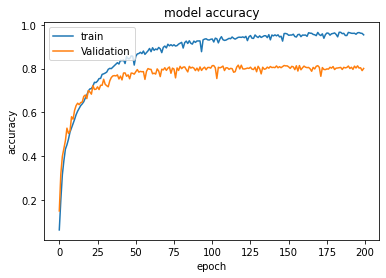

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model = load_model('/content/drive/MyDrive/building1/225gridnoWiFiBT27March5slots_200epochs_biDirLSTMDoubleDenseDropout/best_model.pkl')

from sklearn.metrics import accuracy_score
y_pred=model.predict(test)
test_preds=( y_pred> 0.5).astype("int32")#Selecting a label only if it has >0.5 probability
accuracy_score(test_target, test_preds)

0.8045267489711934

In [ ]:
yhat=np.argmax(y_pred,axis=1)
y=np.argmax(test_target,axis=1)
accuracy_score(y,yhat)

0.8124142661179699

In [ ]:
#converting predicted labels to waypoins.
pred_df=pd.DataFrame(yhat,columns=['Label'])
label_df=pd.DataFrame(label,columns=['X_up_limit','Y_up_limit','Label'])
label_df.head()
pred_df2 = pd.merge(pred_df, label_df, on='Label', how='left')
pred_df2.head()

,Label,X_up_limit,Y_up_limit
0,177,207.636228,169.39878
1,177,207.636228,169.39878
2,177,207.636228,169.39878
3,177,207.636228,169.39878
4,177,207.636228,169.39878


In [ ]:
wp_pred=list()
#Adjust wp to centers
distx=(label[1][0]-label[0][0])/2
disty=(label[25][1]-label[0][1])/2 #for 25X25 grid
pred_df2['X_up_limit']=pred_df2['X_up_limit']-distx
pred_df2['Y_up_limit']=pred_df2['Y_up_limit']-disty
pred_df2.head()

,Label,X_up_limit,Y_up_limit
0,177,201.05924,165.465708
1,177,201.05924,165.465708
2,177,201.05924,165.465708
3,177,201.05924,165.465708
4,177,201.05924,165.465708


In [ ]:
#Now we will calculate exact error in predicted and actual location
#We will consider only those waypoints which were present in the original data
#to calculate error and we will reject interpolated values which were introduced by us 
import math
sum_of_error=0
sum_sq_error=0
count=0
test_predicted=pred_df2[['X_up_limit','Y_up_limit']].values
for i in range(len(test_seq_wp)):
  for j in range(len(test_seq_wp[i])):
    if(test_seq_wp[i][j][2]==1):
      sum_of_error+=math.sqrt(((test_predicted[i][0]-test_seq_wp[i][j][0])**2)+((test_predicted[i][1]-test_seq_wp[i][j][1])**2))
      sum_sq_error+=((test_predicted[i][0]-test_seq_wp[i][j][0])**2)+((test_predicted[i][1]-test_seq_wp[i][j][1])**2)
      count+=1


MAE=sum_of_error/count
RMSE=math.sqrt(sum_sq_error/count)
print('MAE value is:',round(MAE,2))  
print('RMSE value is:',round(RMSE,2)) 

MAE value is: 14.93
RMSE value is: 24.09
